# Productivizacion modelo ML

### Introducción

Partimos con los siguientes elementos:

- La carpeta traincontainer donde se almacenan los archivos clave.
- Dentro de esta carpeta, tenemos un Dockerfile con el que construiremos la imagen que será enviada a Google Container Registry (GCR) para su uso en el entrenamiento.
- También hay una carpeta llamada trainer, donde se encuentra el código de entrenamiento.
- Dentro de nuestro bucket se almacenará el modelo entrenado, para llevar a producción

In [1]:
!tree 

.
├── 02_customtrain.ipynb
└── traincontainer
    ├── Dockerfile
    └── trainer
        └── train.py

2 directories, 3 files


## 1. Entrenamiento custom: Docker

### 1.1. Dockerfile

### Revisión de dockerfile y código de entrenamiento

Veamos lo que tiene la imagen:

In [14]:
!cat traincontainer/Dockerfile

FROM gcr.io/deeplearning-platform-release/sklearn-cpu.0-23
WORKDIR /

# Copies the trainer code to the docker image.
COPY trainer /trainer

RUN pip install scikit-learn google-cloud-bigquery joblib pandas google-cloud-storage kfp

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.train"]


Lo único que hace es copiar el código de entrenamiento para poder ejecutarlo desde ahí e instalar algunas dependencias. Otro punto para destacar es que el FROM parte de una imagen ya preparada por Google, que en este caso es bastante sencilla. La lista completa se encuentra aquí: https://cloud.google.com/deep-learning-containers/docs/choosing-container

Veamos a continuación el código de entrenamiento:

### 1.2. Definición del modelo

**Importante:** El código que está subido al repo es de aplicación genérica y si quieres obtener información de tu propio bucket reemplaza esto "productivizacion_modelo_ml_bucket" por el nombre de tu bucket y el nombre de tu tabla.

In [3]:
!cat traincontainer/trainer/train.py

from sklearn.tree import DecisionTreeClassifier
from joblib import dump
from sklearn.model_selection import train_test_split
import os
import pandas as pd

# Importar las bibliotecas necesarias para trabajar con GCP
from google.cloud import storage

# Crea un cliente de almacenamiento GCS
storage_client = storage.Client()

# Ubicación del archivo CSV en GCS
gcs_csv_uri = 'gs://productivizacion_modelo_ml_bucket/iris_dataset.csv'

# Lee el archivo CSV directamente desde GCS a un DataFrame de Pandas
df = pd.read_csv(gcs_csv_uri, sep=';')

# Separa tus datos en características (X) y etiquetas (y)
X = df.drop('target', axis=1)
y = df['target']

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define y entrena tu modelo en el conjunto de entrenamiento
skmodel = DecisionTreeClassifier()
skmodel.fit(X_train, y_train)

# Evalúa el modelo en el conjunto de prueba (calcula la precisión)
accuracy 

### 1.3. Obtención de PROJECT_ID

In [5]:
import os
PROJECT_ID = ""
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]

### 1.4. Construir la imagen

En este paso tenemos que construir el contenedor de Docker, usando para ello el Dockerfile y el código que acabamos de modificar.

En el contexto de GCP, el microservicio dedicado al almacenamiento y manejo de imágenes de Docker se llama Google Container Registry (GCR) y es ahí donde tenemos que subir lo que vamos a construir.

Veamos la URI donde se alojará:

Vamos a hacer el build de la imagen desde una terminal. Primero necesitamos armar el DOCKER_IMAGE_URI, que es donde quedará la imagen.

In [15]:
DOCKER_IMAGE_URI = f'gcr.io/{PROJECT_ID}/workshop-sklearn-beans:v1'
f'La uri de la imagen es: {DOCKER_IMAGE_URI}'

'La uri de la imagen es: gcr.io/productivizacion-modelo-ml/workshop-sklearn-beans:v1'

La próxima celda ejecuta código bash para subir la imagen a GCR. Lo que vas a ver en la ejecución de la celda es mi resultado: lo que tenés que hacer es descomentar la celda y ejecutarla **solo una vez**, de forma tal que quede tu imagen que contiene las especificaciones de tu bucket quede alojada en el registro.

In [16]:
#!docker build ./traincontainer/ -t $DOCKER_IMAGE_URI

Sending build context to Docker daemon  9.216kB
Step 1/5 : FROM gcr.io/deeplearning-platform-release/sklearn-cpu.0-23
 ---> 3b7bb510cd2e
Step 2/5 : WORKDIR /
 ---> Using cache
 ---> cfe93966fb9c
Step 3/5 : COPY trainer /trainer
 ---> Using cache
 ---> c247f0251073
Step 4/5 : RUN pip install scikit-learn google-cloud-bigquery joblib pandas google-cloud-storage kfp
 ---> Running in 1aa0a362a4b2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.4/372.4 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.8 MB/s eta 0:00:00
  Created wheel for kfp: filename=kfp-2.1.3-py3-none-any.whl size=521300 sha256=

Usamos un poco más de bash para subir la imagen de Docker cuyo nombre acabamos de generar. Aplica lo mismo que arriba: se corre **sólo una vez**, para subir tu imagen a tu repositorio.

In [17]:
 #!docker push $DOCKER_IMAGE_URI

The push refers to repository [gcr.io/productivizacion-modelo-ml/workshop-sklearn-beans]

c50e7989: Preparing 
d7c69556: Preparing 
640f94d4: Preparing 
b945b486: Preparing 
2001452c: Preparing 
8df3ecaf: Preparing 
561372ae: Preparing 
28e35d43: Preparing 
27439f5f: Preparing 
16aec5bc: Preparing 
22fb107f: Preparing 
1c1d0d06: Preparing 
5662acff: Preparing 
e9d7c2ff: Preparing 
fdb4bf7f: Preparing 
ebd9a5b1: Preparing 
a6a0193c: Preparing 
44bbff66: Preparing 
29d2230d: Preparing 
bf18a086: Preparing 
b4134c81: Preparing 
bf18a086: Preparing 
04701469: Preparing 
3a649476: Preparing 
50e7989: Pushed   32.72MB/31.08MBv1: digest: sha256:f682d8e2b1bcbe51b84f26ce0b0e7df58be6ddc43251bb350f9a937244396894 size: 5757


Si todo salió bien, deberíamos poder ver la imagen en el listado de las que están en GCR. Pueden buscar el servicio y revisarlo, como vemos a continuación:

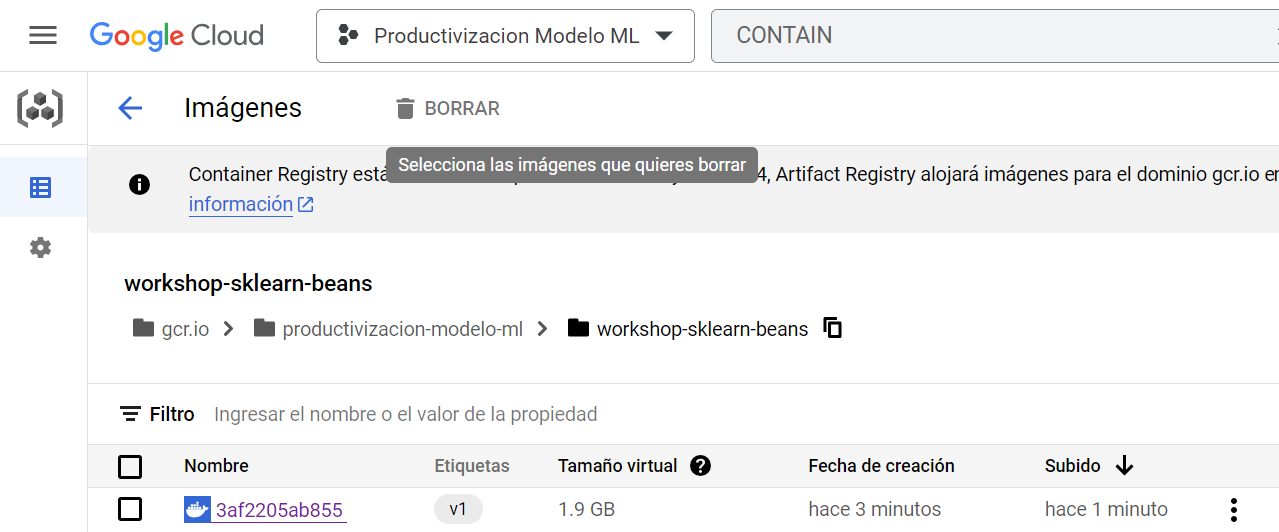

## 2. Configurar la predicción batch

Obtenemos data iris_dataset.csv desde nuestro bucket

In [11]:
from google.cloud import storage

# Especifica el nombre de tu proyecto y el nombre del bucket
project_id = 'productivizacion-modelo-ml'
bucket_name = 'productivizacion_modelo_ml_bucket'
blob_name = 'iris_dataset.csv'  # Nombre del archivo que deseas descargar
destination_file_path = 'iris_dataset.csv'  # Ruta local donde guardarás el archivo

# Crea una instancia del cliente de almacenamiento de Google Cloud
client = storage.Client(project=project_id)

# Obtiene una referencia al bucket
bucket = client.bucket(bucket_name)

# Obtiene una referencia al objeto (archivo) en el bucket
blob = bucket.blob(blob_name)

# Descarga el archivo a la ruta local
blob.download_to_filename(destination_file_path)

print(f'Archivo descargado a {destination_file_path}')


Archivo descargado a iris_dataset.csv


## 3. Armado del pipeline

Este pipeline sencillo va hacer tres cosas:
- Crear un dataset de Vertex AI
- Correr un training job usando el container custom que armamos
- Correr un batch prediction job con el modelo entrenado.

En este caso, vamos a estar utilizando componentes preconstruidos de Kubeflow así que tenemos el camino un poco más allanado.

In [29]:
#!pip install kfp
#!pip install --upgrade google-cloud-aiplatform google-cloud-pipeline-components

In [2]:
import os
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)
    
BUCKET_NAME = 'gs://productivizacion_modelo_ml_bucket'

PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin
REGION="us-central1"

PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_root/"
PIPELINE_ROOT

from kfp.v2 import compiler
from kfp.v2.dsl import pipeline

from google.cloud import aiplatform
#from google_cloud_pipeline_components import aiplatform as gcc_aip
from datetime import datetime


TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

PIPELINE_NAME = "pipeline-vertex-customtraining"
PACKAGE_PATH = f"pipeline-vertex-customtraining.json"
DISPLAY_RUN_NAME = f'{PIPELINE_NAME}-{TIMESTAMP}'


Project ID:  productivizacion-modelo-ml
env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin


Con todo esto, ahora sí podemos crear el pipeline.

In [3]:
@pipeline(
    name=PIPELINE_NAME,
    pipeline_root=PIPELINE_ROOT
)
def pipeline(
    bq_source: str = "gs://productivizacion_modelo_ml_bucket/iris_dataset.csv",
    bucket: str = BUCKET_NAME,
    project: str = PROJECT_ID,
    gcp_region: str = REGION,
    bq_dest: str = "",
    container_uri: str = "",
    batch_destination: str = "productivizacion-modelo-ml.dataset_ouput.tabla_output"
):
    dataset_create_op = gcc_aip.TabularDatasetCreateOp(
        display_name="tabular-beans-dataset",
        bq_source=bq_source,
        project=project,
        location=gcp_region
    )

    training_op = gcc_aip.CustomContainerTrainingJobRunOp(
        display_name=DISPLAY_RUN_NAME,
        container_uri=container_uri,
        project=project,
        location=gcp_region,
        dataset=dataset_create_op.outputs["dataset"],
        staging_bucket=bucket,
        training_fraction_split=0.8,
        validation_fraction_split=0.1,
        test_fraction_split=0.1,
        bigquery_destination=bq_dest,
        model_serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest",
        model_display_name="scikit-beans-model-pipeline",
        machine_type="n1-standard-4",
    )
    batch_predict_op = gcc_aip.ModelBatchPredictOp(
        project=project,
        location=gcp_region,
        job_display_name=f"{PIPELINE_NAME}-predict",
        model=training_op.outputs["model"],
        gcs_source_uris=["{0}/iris_dataset.csv".format(BUCKET_NAME)],
        instances_format="csv",
        gcs_destination_output_uri_prefix=batch_destination,
        machine_type="n1-standard-4"
    )


Este es el esqueleto básico del pipeline. Hay un par de variables que se le pasan desde la ejecución del pipeline (por ejemplo, el container_uri de la imagen que tiene el modelo adentro). Con esta definición, el próximo paso es compilarlo:

In [4]:
compiler.Compiler().compile(
    pipeline_func=pipeline, package_path=PACKAGE_PATH
)


/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


Esto nos deja preparado un json que podemos reutilizar en otras ocasiones.

Vamos a capturar el timestamp actual y usarlo también como argumento en la definición del job del pipeline:

In [5]:
pipeline_job = aiplatform.PipelineJob(
    display_name=PIPELINE_NAME,
    template_path=PACKAGE_PATH,
    job_id=f'{PIPELINE_NAME}-{TIMESTAMP}',
    parameter_values={
        "project": PROJECT_ID,
        "bucket": BUCKET_NAME,
        "bq_dest": "bq://{0}".format(PROJECT_ID),
        "container_uri": "gcr.io/{0}/workshop-sklearn-beans:v1".format(PROJECT_ID),
        "batch_destination": "{0}/batchpredresults".format(BUCKET_NAME)
    },
    enable_caching=True,
)


Por último, sólo queda submitear el job:

In [6]:
pipeline_job.submit()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/696333388420/locations/us-central1/pipelineJobs/workshop-vertex-customtraining-20220614185310
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/696333388420/locations/us-central1/pipelineJobs/workshop-vertex-customtraining-20220614185310')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/workshop-vertex-customtraining-20220614185310?project=696333388420


### Analizando los componentes

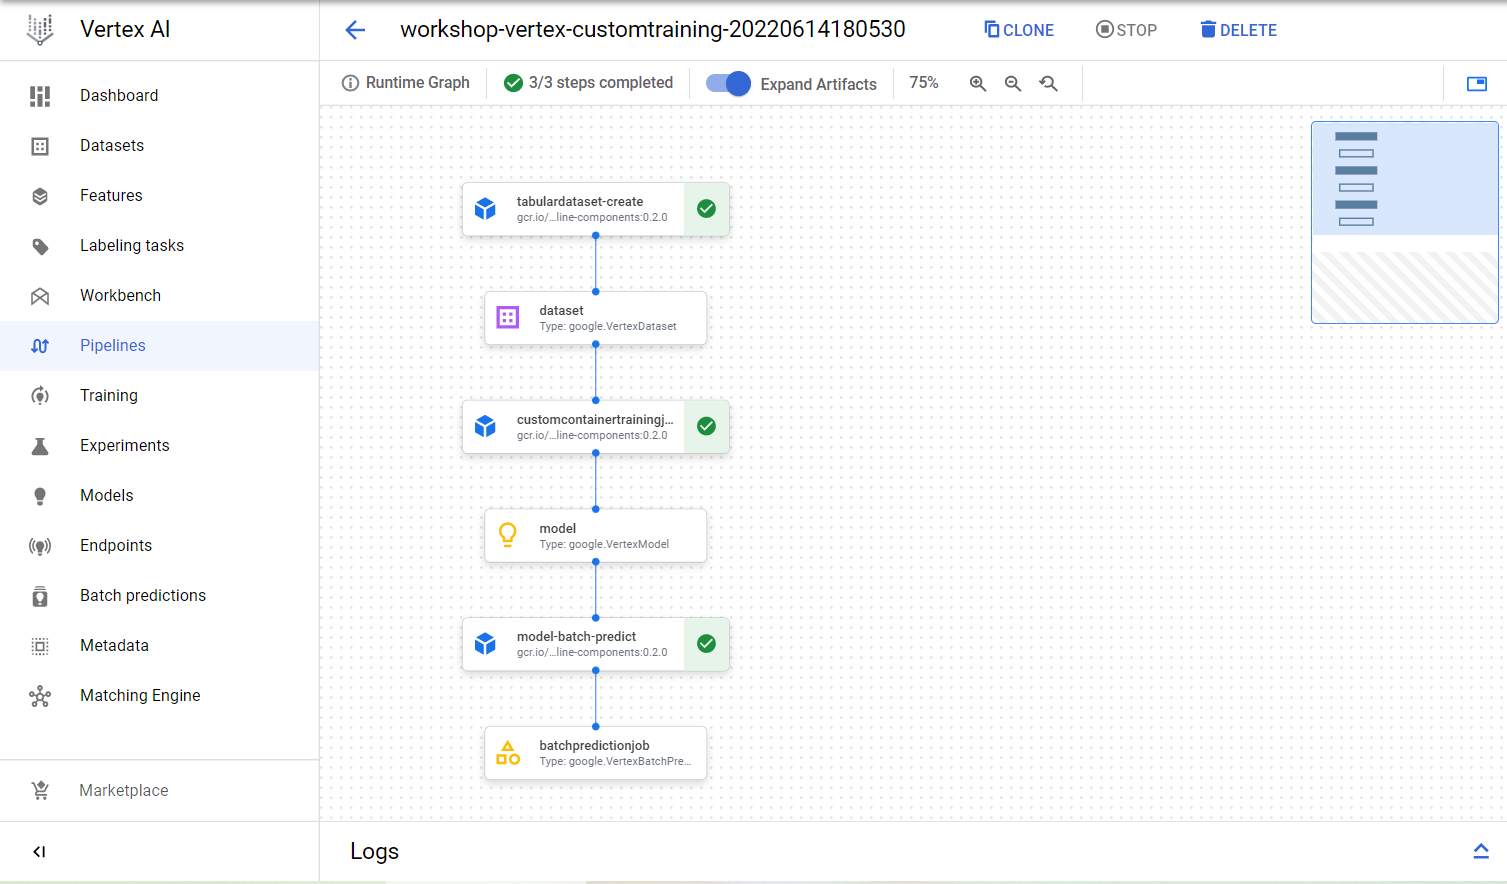

En la parte de Vertex -> Datasets vemos que está creado el dataset que preparamos desde el pipeline. Desde acá se puede usar este dataset para entrenar modelos custom o de AutoML. Un punto importante es que estos datasets manejados cuentan con una serie de variables que se usan en la parte siguiente del pipeline (como el split train/val/test).

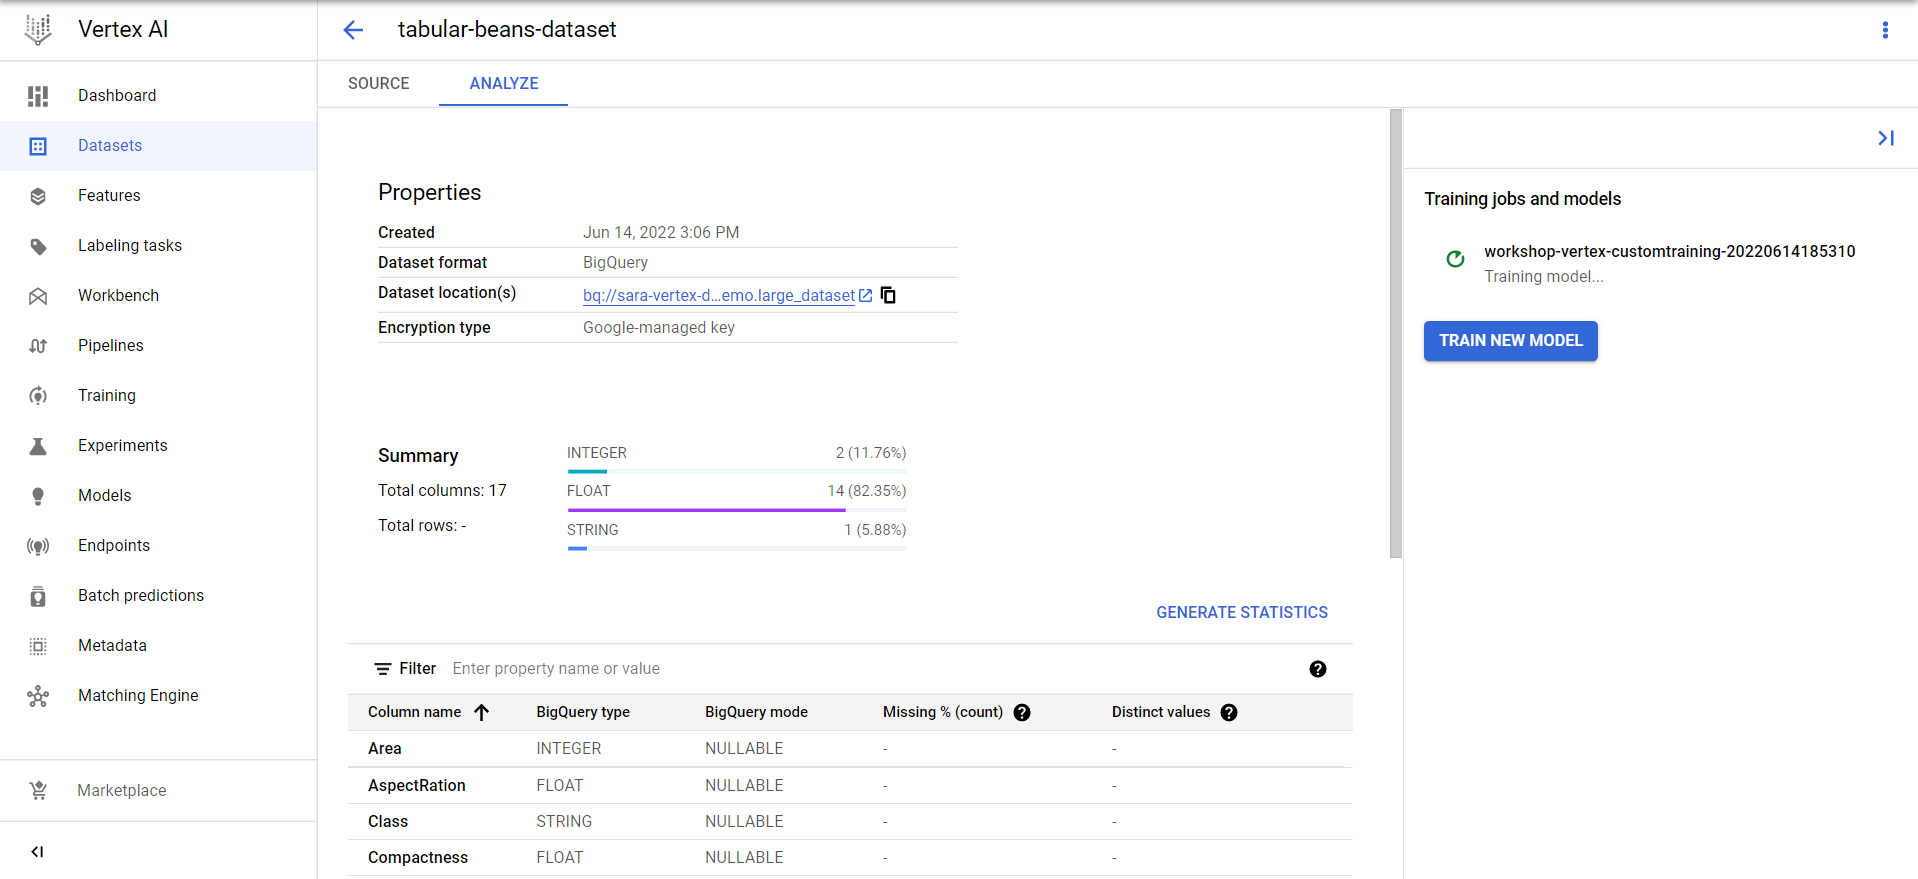

En la parte de Vertex -> Models podemos ver nuestro modelo ya preparado. 

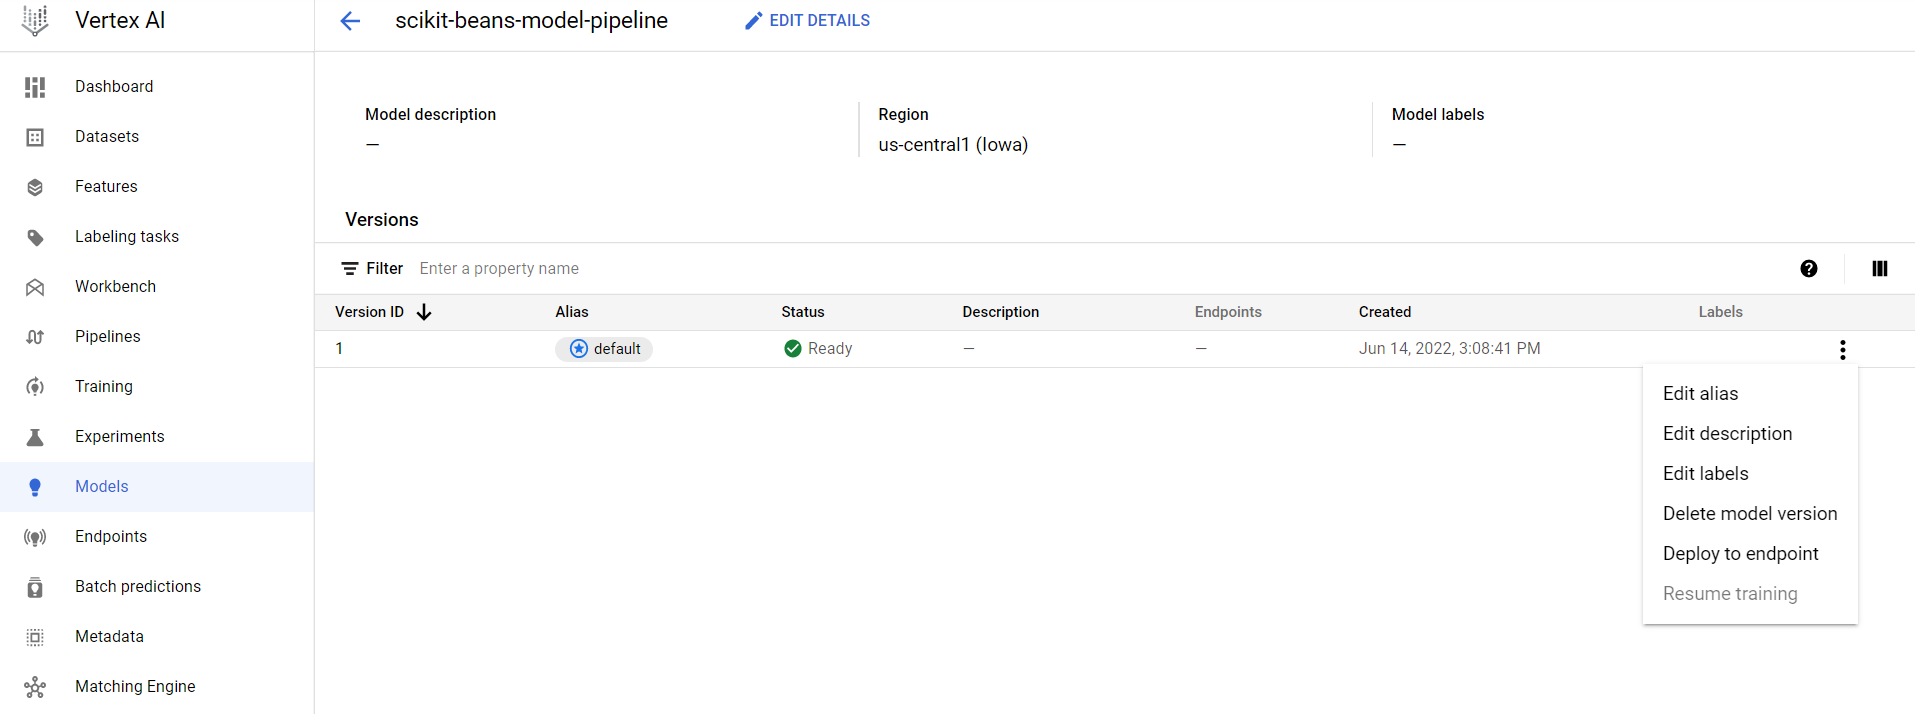

Por último, revisemos un poco qué pasó en el bucket donde se almacena todo:

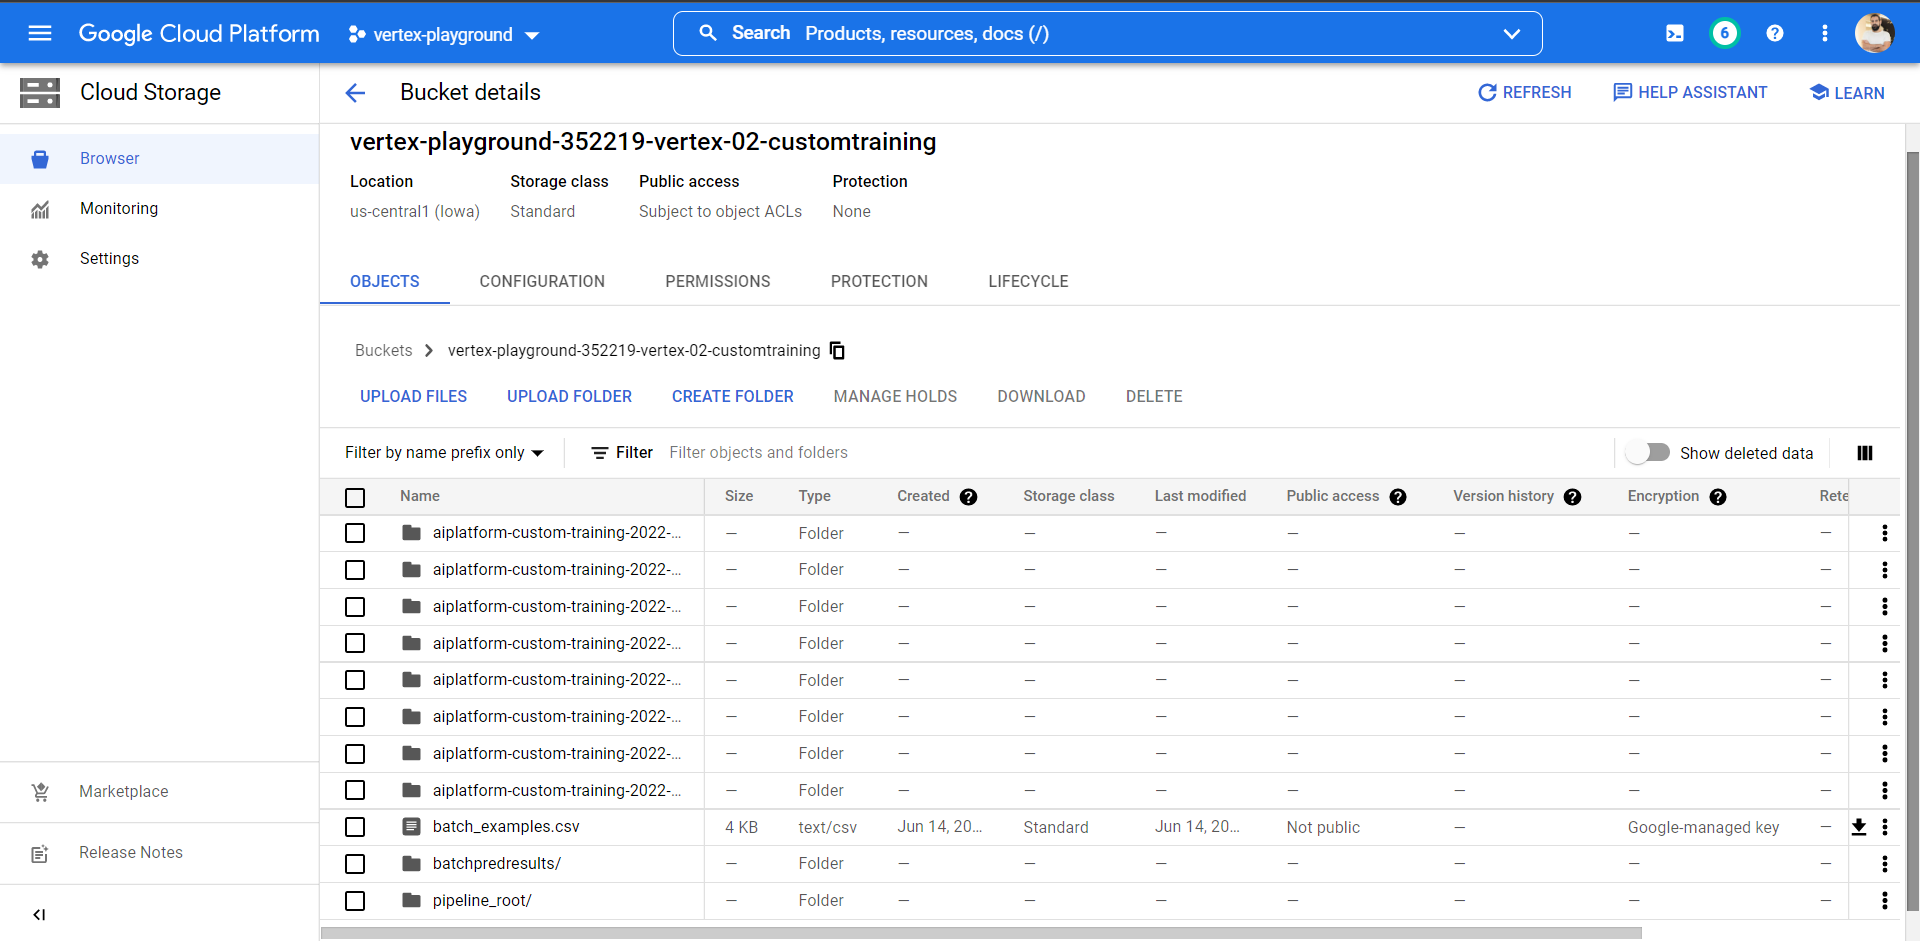

Vean qué rápido se va llenando de mugre! Por eso es tan importante una gestión correcta de artefactos y metadata (y ahí es lo que servicios como Vertex intentan aliviar, a su manera).

- Tenemos por un lado la carpeta donde se almacenan los resultados de la predcición (batchpredresults), que es donde va a buscar todo la parte de Vertex Models que vimos arriba.
- En la carpeta pipeline_root se almacenan artefactos de las distintas ejecuciones. Creo que no vamos a encontrar nada muy útil ahí.
- Pero en las carpetas de los distintos jobs de training vemos que está el modelo terminado:

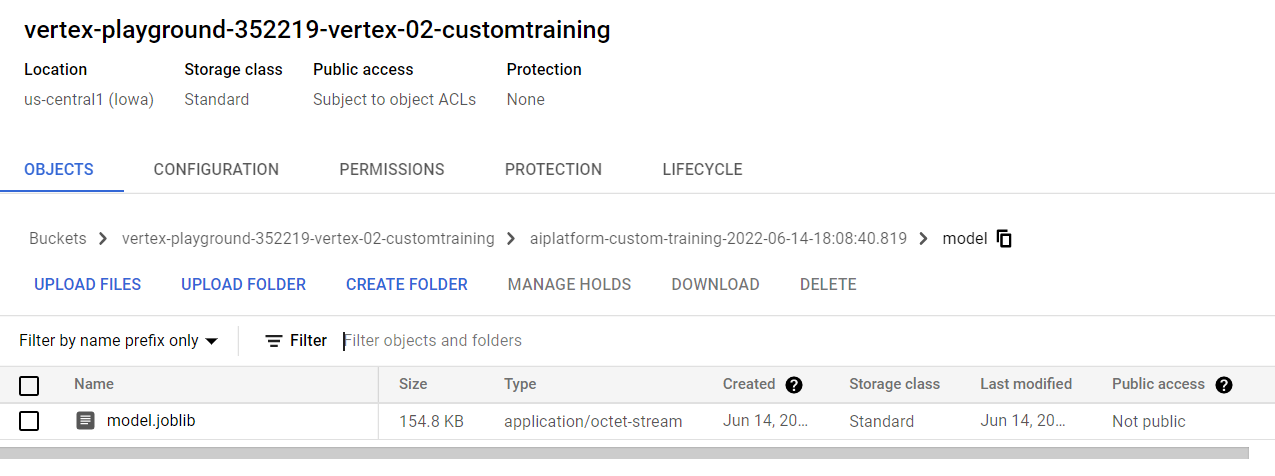

In [8]:
#!pip install google-cloud-secret-manager


### 4. Obtenemos los secretos

In [9]:
from google.cloud import secretmanager_v1
from google.oauth2 import service_account

# Carga las credenciales del servicio (puede variar según tu configuración)
credentials = service_account.Credentials.from_service_account_file(
    'archivo_de_credenciales.json'
)

# Crea un cliente de Secret Manager
client = secretmanager_v1.SecretManagerServiceClient(credentials=credentials)

# ID del proyecto y el nombre del secreto
project_id = 'productivizacion-modelo-ml'
secret_id = 'secret_manager'

# Recupera el valor del secreto
response = client.access_secret_version(name=f'projects/{project_id}/secrets/{secret_id}/versions/latest')

# Obtiene el valor del secreto
secret_value = response.payload.data.decode('UTF-8')
